#**Итоговый проект**#  

**Проведение статистического анализа данных.**  

В качестве источника данных выступает база данных "apteka".  
Изучим собранные данные о работе аптек, сформируем статистические гипотезы и проверим их.

##Загрузка и изучение данных##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
from math import *
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
!pip install scikit-posthocs
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
plt.rcParams["figure.figsize"] = (8,4)

Загрузим файлы с информацией по продажам из аптек и объединим два датасета.

In [2]:
sales = pd.read_csv('sales.csv')
employee = pd.read_csv('employee.csv')
df = sales.merge(employee, left_on='dr_tabempl', right_on='emp_tabn', how='left')
df.head(1)

,dr_dat,dr_tim,dr_nchk,dr_ndoc,dr_apt,dr_kkm,dr_tdoc,dr_tpay,dr_cdrugs,dr_ndrugs,dr_suppl,dr_prod,dr_kol,dr_czak,dr_croz,dr_sdisc,dr_cdisc,dr_bcdisc,dr_tabempl,dr_pos,dr_vzak,emp_tabn,emp_fio
0,2022-05-01,08:33:09,6251,7001554,7,22553,Розничная реализация,18,20398,"ОТРИВИН 0,1% 10МЛ. №1 НАЗАЛ.СПРЕЙ ФЛ. /ГЛАКСО/...",Фармкомплект ООО,Новартис Консьюмер Хелс С.А.,1.0,146.0,175.0,8.0,9.0,2.000100e+11,37,1,1,37,Вцрмцитр Врцхзнжзр Итрзитзр


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45128 entries, 0 to 45127
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dr_dat      45128 non-null  object 
 1   dr_tim      45128 non-null  object 
 2   dr_nchk     45128 non-null  int64  
 3   dr_ndoc     45128 non-null  int64  
 4   dr_apt      45128 non-null  int64  
 5   dr_kkm      45128 non-null  int64  
 6   dr_tdoc     45128 non-null  object 
 7   dr_tpay     45128 non-null  int64  
 8   dr_cdrugs   45128 non-null  int64  
 9   dr_ndrugs   45128 non-null  object 
 10  dr_suppl    45128 non-null  object 
 11  dr_prod     45128 non-null  object 
 12  dr_kol      45128 non-null  float64
 13  dr_czak     45128 non-null  float64
 14  dr_croz     45128 non-null  float64
 15  dr_sdisc    45128 non-null  float64
 16  dr_cdisc    17936 non-null  float64
 17  dr_bcdisc   17936 non-null  float64
 18  dr_tabempl  45128 non-null  int64  
 19  dr_pos      45128 non-nul

In [4]:
df[df['dr_cdisc'].isna()].sample(3)

,dr_dat,dr_tim,dr_nchk,dr_ndoc,dr_apt,dr_kkm,dr_tdoc,dr_tpay,dr_cdrugs,dr_ndrugs,dr_suppl,dr_prod,dr_kol,dr_czak,dr_croz,dr_sdisc,dr_cdisc,dr_bcdisc,dr_tabempl,dr_pos,dr_vzak,emp_tabn,emp_fio
26482,2022-05-24,19:01:37,4999,13001833,13,22589,Розничная реализация,18,497068,СТРЕПТОЦИД 2Г. №1 ПОР. Д/НАРУЖ.ПРИМ. ПАК. /МЕЛ...,Катрен г.Химки,МЕЛИГЕН,1.0,11.48,18.0,0.0,NaN,NaN,29,8,1,29,Мжарцхтмцря Трщрлр Ацхцмрзфлитзр
18866,2022-05-18,15:30:38,5803,18001449,18,9906,Розничная реализация,18,62072,ХАРТМАНН КОСМОПОР Е ПОВЯЗКА 10СМХ8СМ №25 П/ОПЕ...,Здравсервис,ПАУЛЬ ХАРТМАНН,0.2,498.53,698.0,0.0,NaN,NaN,25,3,1,25,Коцысци Илжзр Нжцицрхтзр
23072,2022-05-21,19:47:19,1151,11004775,11,23925,Розничная реализация,18,6286,ЗЕЛЕНЫЙ ДОКТОР ШАЛФЕЙ №20 ТАБ. Д/РАСС. /НАТУР ...,ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,H.TEN HERKEL B.V. (ХЕРКЕЛЬ ),1.0,215.19,297.0,0.0,NaN,NaN,30,1,1,30,Сжлинци Мрлжя Врцхлжхтзр


Как видно пропуски в данных есть только в столбцах с кодом и штрих-кодом скидок. Нас данная информация не интересует, так как в данном случае в столбце с суммой скидки указан 0.  
Изменим тип данных в столбцах с датой и временем. Столбец с временем преобразуем в конкретный час.

In [5]:
df['dr_dat'] = df['dr_dat'].astype('datetime64[ns]')
df['dr_tim'] = df['dr_tim'].astype('datetime64[ns]').dt.hour

Так как чек можно определить как комбинацию даты, номера аптеки и номера чека, то объединим данные столбцы, для получения уникального id покупки.


In [6]:
df['chek'] = df['dr_dat'].astype(str) + " " + df['dr_apt'].astype(str) + " " + df['dr_nchk'].astype(str)

Для будущего анализа создадим столбец с временем суток, в котором 16 часов рабочей смены разделим на 4 равные части: утро, полдень, день и вечер.

In [7]:
df['daypart'] = np.where(df['dr_tim'] < 11, 'утро',
                np.where(df['dr_tim'] < 15, 'полдень',
                np.where(df['dr_tim'] < 19, 'день','вечер')))

Избавимся от отрицательных значений в столбцах.

In [8]:
for i in df['dr_kol']:
  if i < 0:
    df['dr_kol'] = df['dr_kol'].replace(i, i*(-1))

In [9]:
for i in df['dr_sdisc']:
  if i < 0:
    df['dr_sdisc'] = df['dr_sdisc'].replace(i, i*(-1))

Создадим отдельный столбец с выручкой.

In [10]:
df['revenue'] = df['dr_kol']*df['dr_croz']-df['dr_sdisc']

Для удобства изменим в столбце с формой платежа: безналичный с 18 на 0, а наличный с 15 на 1.

In [11]:
dic = {18:0, 15:1}
df['dr_tpay'] = df['dr_tpay'].replace(dic)

Избавимся от лишней информации в таблице.

In [12]:
df.columns

Index(['dr_dat', 'dr_tim', 'dr_nchk', 'dr_ndoc', 'dr_apt', 'dr_kkm', 'dr_tdoc',
       'dr_tpay', 'dr_cdrugs', 'dr_ndrugs', 'dr_suppl', 'dr_prod', 'dr_kol',
       'dr_czak', 'dr_croz', 'dr_sdisc', 'dr_cdisc', 'dr_bcdisc', 'dr_tabempl',
       'dr_pos', 'dr_vzak', 'emp_tabn', 'emp_fio', 'chek', 'daypart',
       'revenue'],
      dtype='object')

In [13]:
df = df[['dr_dat', 'dr_tim', 'dr_apt', 'dr_tpay', 'dr_cdrugs', 'dr_ndrugs', 'dr_suppl',
         'dr_vzak', 'emp_tabn', 'emp_fio', 'chek', 'daypart','revenue']]
df.head(1)

,dr_dat,dr_tim,dr_apt,dr_tpay,dr_cdrugs,dr_ndrugs,dr_suppl,dr_vzak,emp_tabn,emp_fio,chek,daypart,revenue
0,2022-05-01,8,7,0,20398,"ОТРИВИН 0,1% 10МЛ. №1 НАЗАЛ.СПРЕЙ ФЛ. /ГЛАКСО/...",Фармкомплект ООО,1,37,Вцрмцитр Врцхзнжзр Итрзитзр,2022-05-01 7 6251,утро,167.0


##Проверка данных на нормальность##

Для проверки сгруппируем данные по чекам, и проверим количество товаров в них и выручку по ним на нормальность.

In [14]:
groupped = (
    df.groupby('chek')
    .agg({'revenue': 'sum', 'dr_cdrugs': 'count'})
    .rename(columns={'revenue':'total_sum', 'dr_cdrugs':'total_cnt'})
)

Посмотрим на основные выборочные характеристики наших данных:

In [15]:
for i in groupped.columns:
  print(i)
  print('Выборочное среднее:', groupped[i].mean()),
  print('Выборочная медиана:', groupped[i].median()),
  print('Выборочная мода:', groupped[i].mode())
  print('Выборочное среднеквадратическое отклонение:', groupped[i].std())
  print('Выборочный коэффициент ассиметрии:', groupped[i].skew(), '\n')

total_sum
Выборочное среднее: 583.1838823606171
Выборочная медиана: 316.0
Выборочная мода: 0    100.0
Name: total_sum, dtype: float64
Выборочное среднеквадратическое отклонение: 866.8801537956891
Выборочный коэффициент ассиметрии: 7.665300745748839 

total_cnt
Выборочное среднее: 2.15541863686297
Выборочная медиана: 1.0
Выборочная мода: 0    1
Name: total_cnt, dtype: int64
Выборочное среднеквадратическое отклонение: 2.0611156527083248
Выборочный коэффициент ассиметрии: 4.520875621603531 



У нормального распределения среднее, медиана и мода должны быть близки. В случае с суммой чека среднее, медиана и мода сильно отличаются. В случае с количеством товаров мода и медиана равны, а среднее отличается. Нормальное распределение симметрично, в наших вариантах коэффициент ассиметрии равен 7.6 и 4.5 соответственно. Все указывает на то, что распределение не симметрично и правый хвост длиннее.  
Оценим распределение признака – построим гистограммы и посмотрим на них: похожи они на «колокол» нормального распределения или нет.

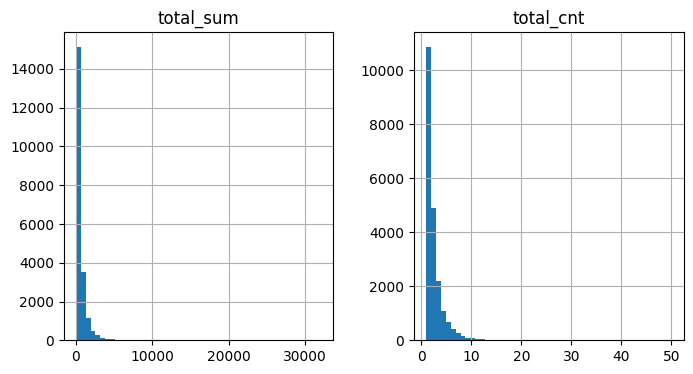

In [16]:
groupped.hist(bins=50);

Гистограммы не похожи на нормальное распределение.  
Построим график квантилей.

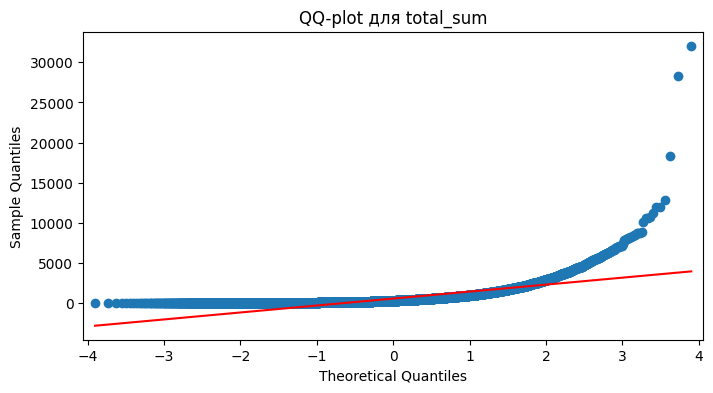

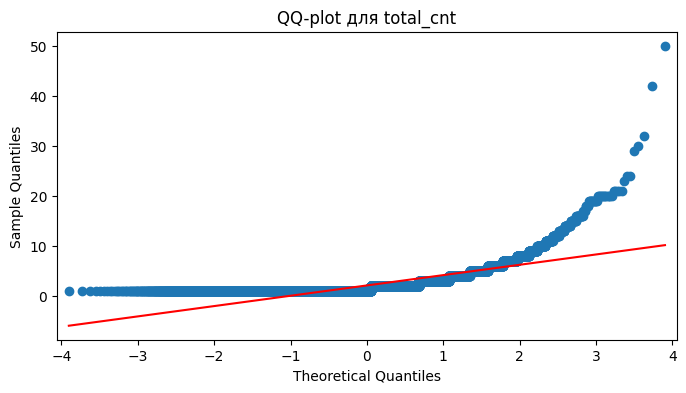

In [17]:
for i in groupped.columns:
  qqplot(groupped[i], line='s')
  plt.title(f'QQ-plot для {i}');

По данным графикам видно, что наши данные не согласуются с нормальными.  
Проверим наши данные с помощью критерия согласия. Нулевую гипотезу сформулируем так: «анализируемая выборка взята из генеральной совокупности, имеющей нормальное распределение». Альтернативная гипотеза: «анализируемая выборка взята из генеральной совокупности, не имеющей нормальное распределение». Возьмем уровень значимости α=0.05.  
Проверим с помощью двух критериев: Шапиро-Уилка и К-квадрат Д'Агостино.

In [18]:
for i in groupped.columns:
  print(i, '\n', shapiro(groupped[i]), '\n', normaltest(groupped[i]), '\n')

total_sum 
 ShapiroResult(statistic=0.5530688273877844, pvalue=1.707731715278148e-114) 
 NormaltestResult(statistic=29016.644241542297, pvalue=0.0) 

total_cnt 
 ShapiroResult(statistic=0.5802244701450483, pvalue=8.221633267788216e-113) 
 NormaltestResult(statistic=20175.644126111554, pvalue=0.0) 



Оба теста показали, что `p-value` крайне мал, а это значит, что нам следует отвергнуть нулевую гипотезу о нормальности данных.

##Проверка статистических гипотез.##


###Гипотеза №1###

Проверим гипотезу о равенстве дисперсий для выручки в сети наших аптек. В качестве альтернативы рассмотрим гипотезу, что хотя бы одна пара дисперсий не равна друг другу. Уровень значимости примем 0.05.

In [19]:
df['dr_apt'].nunique()

8

В данных имеется 8 аптек.  
Избавимся от выбросов в столбце с выручкой, использую правило 3 сигм.

In [20]:
df = df[~((df['revenue'] < df['revenue'].mean() - 3*df['revenue'].std())
        | (df['revenue'] > df['revenue'].mean() + 3*df['revenue'].std()))]

Создадим восемь выборок с аптечной выручкой.

In [21]:
# посчитаем суммы чеков
apt = df.groupby(['dr_apt', 'chek'])['revenue'].sum().reset_index()

# найдем какие аптеки представлены в наших данных
pharmacies = list(df['dr_apt'].unique())

# сделаем выборки с выручкой по каждой аптеке
dic = {}
for i in pharmacies:
  dic[i] = list(apt[apt['dr_apt']==i]['revenue'])

dic.keys()

dict_keys([7, 6, 2, 15, 11, 18, 17, 13])

Сравним дисперсии с помощью критерия *Левена*, так как он позволяет сравнивать дисперсии двух и более групп.

In [22]:
res = levene(dic[7], dic[6], dic[2], dic[15], dic[11], dic[18], dic[17], dic[13])
res

LeveneResult(statistic=46.37659039566146, pvalue=1.1185136204882744e-65)

pvalue крайне мал и стремится к нулю. То есть если проверять гипотезу на уровне значимости 0.05, то у нас есть основания отвергнуть гипотезу о равенстве дисперсий.

Так как статистика имеет распределение Фишера, можно вручную найти p-value и сравнить результат:

In [23]:
k = 8
n = len(apt)
pvalue = f.sf(res.statistic, dfn=k-1, dfd=n-k)
pvalue

1.1185136204882744e-65

Ответы совпадают, поэтому отвергаем гипотезу о равенстве дисперсий.

In [24]:
# посмотрим на выборочные дисперсии
[np.var(x, ddof=1) for x in [dic[7], dic[18], dic[6], dic[2], dic[11], dic[13], dic[15], dic[17]]]

[244689.95500919654,
 217481.31605443056,
 442382.674815365,
 495576.7652304906,
 305142.2642879583,
 339293.7767079889,
 245988.02425449897,
 301709.6529768544]

Заметно, что дисперсии сильно разнятся. Можно выделить три группы аптек, где они достаточно близки: первая группа -  это 7 и 18 аптеки, вторая - 6 и 2 аптеки, третья - 11, 13, 15, 17 аптеки.

In [25]:
print(levene(dic[7], dic[18]))
print(levene(dic[6], dic[2]))
print(levene(dic[11], dic[13], dic[15],dic[17]))

LeveneResult(statistic=0.14868691703732478, pvalue=0.699806377778178)
LeveneResult(statistic=3.817875910728978, pvalue=0.05076300325213695)
LeveneResult(statistic=2.305103969216604, pvalue=0.07471968839808153)


Тест подтвердил, что на уровне значимости 0.05, дисперсии в данных группах равны.  
Можно сделать вывод, что данные группы аптек, что-то объединяет, возможно их местоположение или подход в работе персонала.

###Гипотеза №2###

Нам необходимо диверсифицировать наши риски в работе с поставщиками, т.е мы не хотим чтобы на одного поставщика приходилось более четверти всех поставок. Для этого определим доверительные интервалы для имеющихся у нас поставщиков. Проверим, есть ли у нас поставщики, которые занимают долю в 25% и более. Используем доверительные интервалы, которые вычислим методом Джеффриса.

Посмотрим на представленность поставщиков в нашей выборке.

In [26]:
freq = df.value_counts('dr_suppl', normalize=True).reset_index()
print(freq)

                                             dr_suppl  proportion
0                                               Пульс    0.258156
1                                      Катрен г.Химки    0.227424
2                                              Протек    0.117880
3                       ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК    0.091610
4                                         Здравсервис    0.048193
5                                              Авеста    0.031791
6                                    Фармкомплект ООО    0.029605
7   Индивидуальный предприниматель Кочанов Андрей ...    0.024558
8                                           Арал плюс    0.021787
9                                         ЕАПТЕКА ООО    0.021697
10                                  ВИТТА КОМПАНИ ООО    0.020751
11                                    ГК Надежда Фарм    0.018655
12                                   Магнит Фарма ООО    0.018317
13                                    ООО "Акцентмед"    0.017596
14        

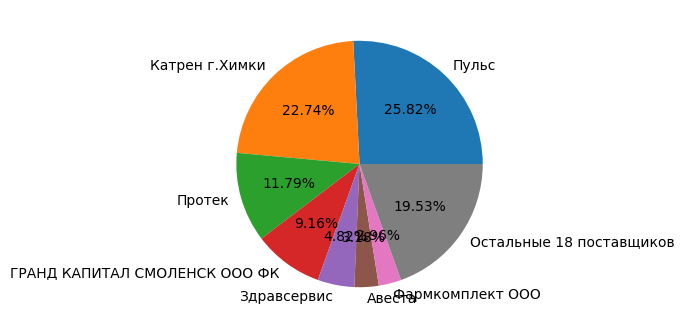

In [27]:
# выведем доли на график
d = {f'Остальные {len(freq)-7} поставщиков': sum(freq.iloc[7:,1])}
add = pd.DataFrame(d.items()).rename(columns={0:'dr_suppl', 1:'proportion'})
freq = pd.concat([freq.iloc[:7,:], add]).reset_index().drop('index', axis=1)
plt.pie(freq['proportion'], labels=freq['dr_suppl'], autopct='%.2f%%');

По нашей выборке поставщик с названием "Пульс" превышает необходимый лимит.  
Построим доверительные интервалы для частот. Для построения нам нужны абсолютные частоты.

In [28]:
# Возьмем 7 основных поставщиков
cnt = df.value_counts('dr_suppl').iloc[:7]

# Объем выборки
N = len(df)

# Создаем датафрем из абсолютных частот и объема выборки
suppliers = pd.DataFrame({'count': cnt,'N':[N] * len(cnt)})

suppliers

,count,N
dr_suppl,,
Пульс,11458,44384
Катрен г.Химки,10094,44384
Протек,5232,44384
ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК,4066,44384
Здравсервис,2139,44384
Авеста,1411,44384
Фармкомплект ООО,1314,44384


Применим функцию `proportion_confint()`. Чтобы не применять функцию к каждому поставщику, создадим функцию, которую будем применять к каждой строке датафрейма:

In [29]:
def calculate_ci(row):
    ci = sm.stats.proportion_confint(row['count'], row['N'], method='jeffreys')
    return pd.Series({'ci_low': ci[0], 'выборочное значение': row['count']/row['N'],  'ci_high': ci[1]})

suppliers_ci = suppliers.apply(calculate_ci, axis=1)

print(suppliers_ci)

                                 ci_low  выборочное значение   ci_high
dr_suppl                                                              
Пульс                          0.254101             0.258156  0.262243
Катрен г.Химки                 0.223543             0.227424  0.231342
Протек                         0.114905             0.117880  0.120905
ГРАНД КАПИТАЛ СМОЛЕНСК ООО ФК  0.088952             0.091610  0.094320
Здравсервис                    0.046230             0.048193  0.050215
Авеста                         0.030189             0.031791  0.033454
Фармкомплект ООО               0.028059             0.029605  0.031213


Как видим для компании-поставщика "Пульс" даже нижняя граница интервала ci_low выходит за установленный лимит 25%. Из чего делаем вывод, что по возможности надо нарастить поставки от других компаний.

###Гипотеза №3###

Проверим гипотезу, что в первой половине мая, ввиду длинных праздничных выходных и связанными с ними последствиями, люди в большем количестве покупают обезбаливающие средства.

*Гипотеза H0:* среднее количество продаж обезбаливающих средств одинаково, как в первой половине мая, так и во второй μ_1 = μ_2.

*Гипотеза H1:* μ_1 > μ_2.

Уровень значимости равен 0.05

В качестве обезбаливающих средств выберем три препарата: кеторол, нимесил и пенталгин.

In [30]:
ket = df[df['dr_ndrugs'].str.contains('КЕТОРОЛ')]
nim = df[df['dr_ndrugs'].str.contains('НИМЕСИЛ')]
pen = df[df['dr_ndrugs'].str.contains('ПЕНТАЛГИН')]
drugs = pd.concat([ket, nim])
drugs = pd.concat([drugs, pen])

In [31]:
# отфильтруем датафрейм по датам
until_may_15 = drugs[drugs['dr_dat']<'2022-05-16']
after_may_15 = drugs[((drugs['dr_dat']>'2022-05-15') & (drugs['dr_dat']<'2022-06-01'))]

# сформируем выборки
group_1 = until_may_15.groupby('dr_dat')['dr_cdrugs'].count()
group_2 = after_may_15.groupby('dr_dat')['dr_cdrugs'].count()

Проверим полученные выборки на нормальность:

In [32]:
print(shapiro(group_1))
print(shapiro(group_2))

ShapiroResult(statistic=0.9550949562100898, pvalue=0.6421982922408861)
ShapiroResult(statistic=0.9753249689313462, pvalue=0.9157246276671672)


Критерий Шапиро-Уилка показывает, что данные распределены нормально. Значит для проверки гипотезы будем использовать параметрический критерий Стьюдента, так как дисперсия ГС нам неизвестна, но она предполагается равной, ввиду того, что продажи были в той же сети аптек.

In [33]:
ttest_ind(group_1, group_2, equal_var=True, nan_policy='propagate', alternative='greater')

TtestResult(statistic=4.00837911591727, pvalue=0.00020543500599725438, df=28.0)

По результатам теста нам необходимо отвергнуть нулевую гипотезу о равенстве средних в пользу альтернативной. Значит действительно в период майских праздников люди чаще обращаются за обезболивающими средствами. А это повод для отдела маркетинга провести в это время соответствующие акции.

###Гипотеза №4###

Мы решили скорректировать нашу рекламную и ценовую политику. Мы предполагаем, что поток клиентов в аптеках в течение дня распределен следующим образом: утро - 10%, полдень - 35%, день - 40%, вечер - 15%, и хотим понять согласуется ли фактический результат с ожидаемым.
Мы имеем дело с категориальной (номинальной) переменной. Значит для проверки гипотезы будем применять критерий хи-квадрат Пирсона.  

*Гипотеза H0:* фактические результаты незначимо отличаются от теоретических.

*Гипотеза H1:* фактические результаты значимо отличаются от теоретических.

Уровень значимости 0.05.

Составим таблицу сопряженности.

In [34]:
# возьмем данные за один месяц без учета майских праздников, так как там поведение покупателей отличается от привычного.
dp = (df[df['dr_dat']>'2022-05-09']
      .groupby('daypart')['chek'].nunique().reset_index().rename(columns={'chek': 'cnt'})
      )

# отсортируем таблицу по времени суток, чтобы далее не путаться в данных
dp['rank'] = np.where(dp['daypart']=='утро',1,
             np.where(dp['daypart']=='полдень',2,
             np.where(dp['daypart']=='день',3,4)))
dp = dp.sort_values('rank').reset_index().drop('index', axis=1)

# формируем таблицу сопряженности
proc = [0.10 , 0.35, 0.40, 0.15]
d = {'Время суток': [i for i in dp['daypart']],
     'Фактические частоты': [i for i in dp['cnt']],
     'Теоретические частоты': [sum(dp['cnt'])*proc[0],
                               sum(dp['cnt'])*proc[1],
                               sum(dp['cnt'])*proc[2],
                               sum(dp['cnt'])*proc[3]]
     }
cont_tab = pd.DataFrame(d)
cont_tab = cont_tab.set_index('Время суток')
cont_tab

,Фактические частоты,Теоретические частоты
Время суток,,
утро,1990,1648.30
полдень,5626,5769.05
день,6001,6593.20
вечер,2866,2472.45


Для проверки гипотезы используем правостороннюю альтернативу. Найдем критическую точку K(1-α) - квантиль хи-квадрат распределения с 3 степенями свободы (так как таблица 2 на 4).

In [35]:
chi2.ppf(1-0.05, 3)

7.814727903251179

Выполним критерий согласия хи-квадрат с помощью функции `chi2_contingency()`.

In [36]:
chi2_contingency(cont_tab)

Chi2ContingencyResult(statistic=90.74609699687335, pvalue=1.5146021231632773e-19, dof=3, expected_freq=array([[1819.15 , 1819.15 ],
       [5697.525, 5697.525],
       [6297.1  , 6297.1  ],
       [2669.225, 2669.225]]))

По результатам теста видно, что статистика равна 90.74 и она попадает в критическую область (7.81; +∞). Уровень значимости равный 0.05 значительно превышает p-value. Значит следует отвергнуть нулевую гипотезу в пользу альтернативной.  
Так как у нас данные только за месяц, то однозначный вывод сделать нельзя, но, если к примеру в выборке за полгода такая же ситуация, то следует пересмотреть нашу рекламную и ценовую политику, но для этого лучше иметь дополнительные данные с характеристиками клиентов.

###Гипотеза №5###  

Предположим, что мы привлекали покупателей на сайт нашей аптеки с трех разных каналов: Вконтакте - с 01.05.2022 по 13.05.2022, Яндекс - с 14.05.2022 по 26.05.2022, Google - с 27.05.2022 по 08.06.2022.  
Мы хотим проверить существуют ли различия в среднем чеке интернет-покупок между пользователями, пришедшими по рекламе из ВКонтакте, Яндекса, Google.  

*Гипотеза H0:* различия в средних чеках отсутствуют

*Гипотеза H1:* имеются различия в средних чеках

Уровень значимости 0.05.

Сформируем необходимые выборки.

In [48]:
# отфильтруем только интернет-покупки
web = df[df['dr_vzak']==2]

# сформируем выборки по рекламным источникам
vk = web[((web['dr_dat']>='2022-05-01') & (web['dr_dat']<='2022-05-13'))]
yandex = web[((web['dr_dat']>='2022-05-14') & (web['dr_dat']<='2022-05-26'))]
google = web[((web['dr_dat']>='2022-05-27') & (web['dr_dat']<='2022-06-08'))]

# сгруппируем выручку по чекам
vk = vk.groupby('chek')['revenue'].sum()
yandex = yandex.groupby('chek')['revenue'].sum()
google = google.groupby('chek')['revenue'].sum()

Мы уже знаем, что данные по выручке имеют распределение отличное от нормального. Но все же проверим новые выборки.

In [49]:
print(shapiro(vk))
print(shapiro(yandex))
print(shapiro(google))

ShapiroResult(statistic=0.8061928897683153, pvalue=1.485812551204626e-15)
ShapiroResult(statistic=0.8017860896520341, pvalue=1.2742874285581146e-16)
ShapiroResult(statistic=0.8672313870742733, pvalue=2.125582376400868e-12)


Снова подтверждается, что распределение в выборках не является нормальным, поэтому будем использовать непараметрические тесты.  
Для бизнеса важно повышать средний чек. Если мы поймем, что есть различия между выборками, то сможем выбрать тот канал, куда следует увеличить рекламный бюджет.

Протестируем гипотезу о том, что нет различий между средним чеком в данных трех каналах, на уровне значимости 0.05. Воспользуемся H-критерием Краскела-Уоллиса:

In [50]:
kruskal(vk, yandex, google)

KruskalResult(statistic=1.500094377519223, pvalue=0.47234426287522857)

pvalue > 0.05, значит мы не должны отвергать гипотезу Н0. То есть между группами нет значимых различий. Интересно все-таки взглянуть как группы соотносятся между собой. Поэтому применим критерий Данна для множественного сравнения.

In [51]:
sp.posthoc_dunn([vk, yandex, google], p_adjust = 'bonferroni')

,1,2,3
1,1.000000,1.0,0.662492
2,1.000000,1.0,1.000000
3,0.662492,1.0,1.000000


В результате получили матрицу попарных сравнений, в которой записаны p-value для соответствующей пары. Здесь все подтверждается, как и в случае с критерием Краскела, мы не можем отвергнуть нулевую гипотезу ни для какой пары.  
Посмотрим на выборочные среднее наших групп:

In [52]:
for i in [(vk,'vk'), (yandex,'yandex'), (google,'google')]:
  print(f'{i[1]}',np.rint(np.mean(i[0])))

vk 1064.0
yandex 1054.0
google 1124.0


Хоть тесты и показали отсутствие значимых различий между средними чеками трех разных каналов, можно отметить, что средние чеки Yandex и VK практически идентичны, поэтому их можно взаимозаменять в случае, если какая-нибудь из площадок будет завышать стоимость рекламы.

###Гипотеза №6###

Предположим, что с 1 июня 2022 г. мы ввели дополнительный кэшбэк баллами при оплате покупок картами. Мы хотим посмотреть на эффект данной акции, и узнать, изменилась ли доля покупателей, оплачивающих по безналу. Сравним доли признака в двух выборках: май и июнь. Проверим гипотезу о равенстве долей. В данном случае выборки будут представлены биноминальным распределением.  

Гипотеза H0: p1 = p2. Уровень значимости α = 0.05.

Гипотеза H1: p1 < p2. Так как мы предполагаем, что доля людей, расплачивающихся картами, должна вырасти.

In [53]:
# сформируем выбоки
may_pay = df[df['dr_dat']<'2022-06-01'].groupby('chek', as_index=False)['dr_tpay'].min()
june_pay = df[df['dr_dat']>'2022-05-31'].groupby('chek', as_index=False)['dr_tpay'].min()

# Объемы выборок
n1 = len(may_pay)
n2 = len(june_pay)

# Количество объектов с признаком в каждой группе
m1 = len(may_pay[may_pay['dr_tpay']==0])
m2 = len(june_pay[june_pay['dr_tpay']==0])

# выборочная доля
p1 = m1/n1
p2 = m2/n2

# совместная доля
p = (m1+m2)/(n1+n2)

Проверим условия применения критерия:

In [54]:
print(n1*p1>5, n1*(1-p1)>5)
print(n2*p2>5, n2*(1-p2)>5)

True True
True True


Рассчитаем значение критерия:

In [55]:
z_obs = (p1-p2)/sqrt(p*(1-p)*(1/n1+1/n2))
z_obs

-0.9410085098673462

Критическая область левосторонняя, значит ищем критическое значение стандартного распределения: K(α):

In [56]:
alpha = 0.05
print(norm.ppf(alpha))

-1.6448536269514729


Критическая область: (-∞; -1.645). Наблюдаемое значение статистики z_obs=-0.941 не попадает в критическую область, значит мы не отклоняем гипотезу о равенстве долей.

Проверим с помощью p-value.

In [57]:
p_value = norm.cdf(z_obs)
p_value

0.17335024911440916

В нашем случае α=0.05 < 0.17, значит мы не отвергаем гипотезу о том, что доли равны.  

Взглянем на проверяемые доли в наших выборках:

In [58]:
print(f'Доля в мае = {round(p1*100, 1)}%, доля в июне = {round(p2*100, 1)}%')

Доля в мае = 62.0%, доля в июне = 62.8%


Доля в июне увеличилась всего на 0.8%, что и впрямь незначительно. Но учитывая, что с начала акции прошло всего 9 дней и посещение аптеки для человека не является повседневной необходимостью, то окончательный вывод делать рано. Поэтому проверку гипотезы необходимо будет повторить через некоторый период на более обширных данных.

###Гипотеза №7###  

Предположим, мы провели мини-курс по повышению квалификации для фармацевтов наших аптек. В качестве обучаемых были работники с табельными номерами от 20 до 30. Мы предполагаем, что применение методов обучения, используемых в курсе, повысило производительность наших сотрудников. Нам необходимо оценить эффективность обучения сотрудников, для чего мы сравним величину среднего чека данных сотрудников до обучения и после. В данном случае нам нужно будет применить критерий для зависимых выборок.  

Гипотеза H0: средний чек до обучения такой же как и после.  

Гипотеза H1: средний чек после обучения стал больше.  

Уровень значимости α = 0.05.

Будем считать, что курс продолжительностью в одну неделю длился с 18.05.2022 по 24.05.2022. Поэтому в качестве выборок будем сравнивать данные из недели до обучения и недели после обучения.

In [59]:
# отфильтруем по табельным номерам и датам
sample_1 = df[((df['emp_tabn'].isin(range(20,30)))
                          & (df['dr_dat']>'2022-05-10')
                          & (df['dr_dat']<'2022-05-18')
                      )]
sample_2 = df[((df['emp_tabn'].isin(range(20,30)))
                          & (df['dr_dat']>'2022-05-24')
                          & (df['dr_dat']<'2022-06-01')
                      )]

# рассчитаем средние чеки до обучения и после
befor_the_training = sample_1.groupby(['emp_tabn', 'chek'])['revenue'].sum().reset_index()
befor_the_training = befor_the_training.groupby('emp_tabn')['revenue'].mean()

after_the_training = sample_2.groupby(['emp_tabn', 'chek'])['revenue'].sum().reset_index()
after_the_training = after_the_training.groupby('emp_tabn')['revenue'].mean()

befor = list(befor_the_training.apply(round))
after = list(after_the_training.apply(round))

Для выбора критерия проверки определим, относятся ли вновь образованные выборки к нормальному распределению.

In [60]:
print(shapiro(befor))
print(shapiro(after))

ShapiroResult(statistic=0.8920645181483451, pvalue=0.36759106502067496)
ShapiroResult(statistic=0.9877785394976437, pvalue=0.9713480412484542)


Тест Шапиро-Уилка показал, что данные распределены нормально. Значит будем использовать параметрический критерий Стьюдента для двух парных выборок, но в начале посчитаем вручную, а потом сравним результаты.

In [61]:
# вычислим разности для каждого измерения
diff =  [x - y for x, y in zip(after, befor)]

# найдем выборочное среднее и исправленное среднее квадратическое отклонение
mean = np.mean(diff)
std = np.std(diff, ddof = 1)

# найдем значение статистики критерия
n = len(diff)
T = mean*sqrt(n)/std

print(T)

0.6774040689852372


Так как альтернатива правосторонняя, то найдем критическую точку K(1-α) - квантиль распределения Стьюдента с n-1 степенью свободы.

In [62]:
alpha = 0.05
t.ppf(1-alpha, n-1)

2.131846786326649

Критическая область: (2.13; +∞).  

Так как статистика критерия не попадает в критическую область, то нет основания отвергать нулевую гипотезу. Значит, у нас нет оснований утверждать, что эффективность фармацевтов улучшилась.

Проверим с помощью p-value - найдем вероятность того, что статистика примет значение большее или равное наблюдаемому:

In [63]:
print(t.sf(T, n-1))

0.2676532306001349


p-value > α = 0.05, значит нет оснований отвергать нулевую гипотезу.  

Теперь проверим с помощью функции `ttest_rel()`, которая реализует критерий Стьюдента.

In [64]:
ttest_rel(after, befor, alternative = 'greater')


TtestResult(statistic=0.6774040689852372, pvalue=0.2676532306001349, df=4)

Результаты оказались идентичными.  

Взглянем на наши выборки со средними чеками:

In [65]:
print(f'размер средних чеков до обучения:    {befor}.')
print(f'размер средних чеков после обучения: {after}.')

размер средних чеков до обучения:    [511, 572, 526, 645, 542].
размер средних чеков после обучения: [538, 603, 588, 667, 474].


Как видим у четверых сотрудников результаты улучшились, а у одного ухудшились. Но как показал тест изменения статистически незначимы. В итоге проведенное обучение не повысило эффективность работы фармацевтов, но следовало бы проверить данную гипотезу на более длительном периоде.